<a href="https://colab.research.google.com/github/Arjavjain100/Apple-Scab-Detection/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!git clone "https://github.com/Arjavjain100/Apple-Scab-Detection.git"

Cloning into 'Apple-Scab-Detection'...
remote: Enumerating objects: 561, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 561 (delta 22), reused 48 (delta 21), pack-reused 510
Receiving objects: 100% (561/561), 1.17 GiB | 20.85 MiB/s, done.
Resolving deltas: 100% (25/25), done.
Checking out files: 100% (1030/1030), done.


In [13]:
# Importing required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torchvision import datasets, transforms, models
from tqdm.auto import tqdm
from torchinfo import summary
import matplotlib.pyplot as plt

In [14]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

In [15]:
# Alexnet from scratch
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding=0))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, 1000))
        self.fc3= nn.Sequential(
            nn.Linear(1000, num_classes))

        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = torch.flatten(out, start_dim =1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [16]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [17]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [18]:

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [19]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [10]:
batch_size = 32

transform = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((227, 227)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((227, 227)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])
}
test_data = datasets.ImageFolder('/content/Apple-Scab-Detection/Augmented Dataset/Test', transform = transform['test'])
train_data = datasets.ImageFolder('/content/Apple-Scab-Detection/Augmented Dataset/Test',  transform = transform['train'])
train_loader = torch.utils.data.DataLoader(
    train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
    test_data, shuffle=True, batch_size=batch_size)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Applying transfer learning
alex = models.alexnet(pretrained=True)
net_add =  nn.Linear(1000, 2)

alex_pt = nn.Sequential(alex, net_add).to(device)
alex_scratch = AlexNet(2).to(device)

criterion = nn.CrossEntropyLoss()

optimizer_scratch = opt.Adam(alex_scratch.parameters(), lr =0.001)
optimizer_pt = opt.Adam(alex_pt.parameters(), lr =0.001)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [21]:
summary(alex_scratch,input_size=[32, 3, 227, 227])

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [32, 2]                   --
├─Sequential: 1-1                        [32, 96, 27, 27]          --
│    └─Conv2d: 2-1                       [32, 96, 55, 55]          34,944
│    └─BatchNorm2d: 2-2                  [32, 96, 55, 55]          192
│    └─ReLU: 2-3                         [32, 96, 55, 55]          --
│    └─MaxPool2d: 2-4                    [32, 96, 27, 27]          --
├─Sequential: 1-2                        [32, 256, 13, 13]         --
│    └─Conv2d: 2-5                       [32, 256, 27, 27]         614,656
│    └─BatchNorm2d: 2-6                  [32, 256, 27, 27]         512
│    └─ReLU: 2-7                         [32, 256, 27, 27]         --
│    └─MaxPool2d: 2-8                    [32, 256, 13, 13]         --
├─Sequential: 1-3                        [32, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [32, 384, 13, 13]         885,120

In [22]:
summary(alex_pt,input_size=[32, 3, 227, 227])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 2]                   --
├─AlexNet: 1-1                           [32, 1000]                --
│    └─Sequential: 2-1                   [32, 256, 6, 6]           --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          23,296
│    │    └─ReLU: 3-2                    [32, 64, 56, 56]          --
│    │    └─MaxPool2d: 3-3               [32, 64, 27, 27]          --
│    │    └─Conv2d: 3-4                  [32, 192, 27, 27]         307,392
│    │    └─ReLU: 3-5                    [32, 192, 27, 27]         --
│    │    └─MaxPool2d: 3-6               [32, 192, 13, 13]         --
│    │    └─Conv2d: 3-7                  [32, 384, 13, 13]         663,936
│    │    └─ReLU: 3-8                    [32, 384, 13, 13]         --
│    │    └─Conv2d: 3-9                  [32, 256, 13, 13]         884,992
│    │    └─ReLU: 3-10                   [32, 256, 13, 13]        

In [23]:
NUM_EPOCHS = 20

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

scratch_results = train(model=alex_scratch, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer_scratch,
                        loss_fn=criterion, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 64.1488 | train_acc: 0.4219 | test_loss: 3.7489 | test_acc: 0.5469
Epoch: 2 | train_loss: 8.4539 | train_acc: 0.6484 | test_loss: 2.0836 | test_acc: 0.5469
Epoch: 3 | train_loss: 3.0133 | train_acc: 0.7891 | test_loss: 1.4150 | test_acc: 0.5469
Epoch: 4 | train_loss: 0.7160 | train_acc: 0.7031 | test_loss: 0.9968 | test_acc: 0.6406
Epoch: 5 | train_loss: 2.0083 | train_acc: 0.5391 | test_loss: 1.3875 | test_acc: 0.4375
Epoch: 6 | train_loss: 0.8357 | train_acc: 0.5781 | test_loss: 0.7177 | test_acc: 0.5938
Epoch: 7 | train_loss: 0.6014 | train_acc: 0.7500 | test_loss: 0.5575 | test_acc: 0.7891
Epoch: 8 | train_loss: 0.6130 | train_acc: 0.7578 | test_loss: 0.6247 | test_acc: 0.6484
Epoch: 9 | train_loss: 0.5310 | train_acc: 0.7500 | test_loss: 0.6886 | test_acc: 0.5547
Epoch: 10 | train_loss: 0.6743 | train_acc: 0.7891 | test_loss: 0.5189 | test_acc: 0.7500
Epoch: 11 | train_loss: 0.4889 | train_acc: 0.7656 | test_loss: 0.5720 | test_acc: 0.7578
Epoch: 12 | train_

In [24]:
NUM_EPOCHS = 20

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

pt_results = train(model=alex_pt, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer_pt,
                        loss_fn=criterion, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 6.3263 | train_acc: 0.6953 | test_loss: 2.0008 | test_acc: 0.7891
Epoch: 2 | train_loss: 1.5338 | train_acc: 0.7031 | test_loss: 0.5317 | test_acc: 0.7891
Epoch: 3 | train_loss: 1.8322 | train_acc: 0.4453 | test_loss: 0.7502 | test_acc: 0.5469
Epoch: 4 | train_loss: 0.7255 | train_acc: 0.5391 | test_loss: 0.7921 | test_acc: 0.2266
Epoch: 5 | train_loss: 0.6949 | train_acc: 0.4844 | test_loss: 2.7672 | test_acc: 0.7891
Epoch: 6 | train_loss: 1.4230 | train_acc: 0.7891 | test_loss: 0.5683 | test_acc: 0.7891
Epoch: 7 | train_loss: 0.5693 | train_acc: 0.7891 | test_loss: 0.5171 | test_acc: 0.7891
Epoch: 8 | train_loss: 0.7263 | train_acc: 0.5469 | test_loss: 0.6352 | test_acc: 0.7812
Epoch: 9 | train_loss: 0.7610 | train_acc: 0.3125 | test_loss: 0.6381 | test_acc: 0.7891
Epoch: 10 | train_loss: 0.5109 | train_acc: 0.7578 | test_loss: 0.5452 | test_acc: 0.7891
Epoch: 11 | train_loss: 0.5534 | train_acc: 0.7891 | test_loss: 0.5820 | test_acc: 0.7891
Epoch: 12 | train_l

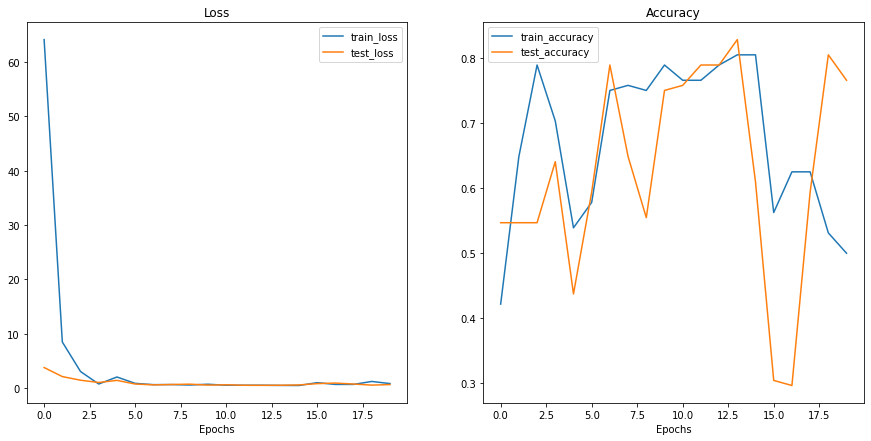

In [28]:
plot_loss_curves(scratch_results)

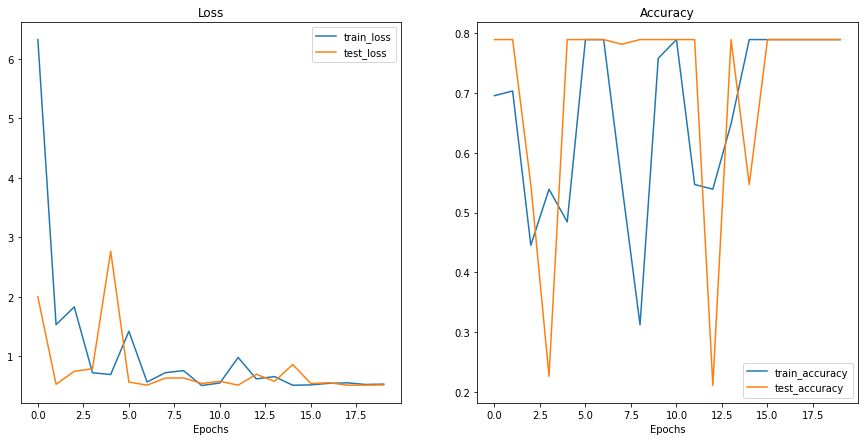

In [27]:
plot_loss_curves(pt_results)